In [1]:
import torch
import numpy as np 
import math

In [9]:
from graphviz import Digraph

In [10]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [157]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''): 
        self.data = data 
        self.grad = 0.0 
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op 
        self.label = label

    def __repr__(self): 
        return f"Value(data={self.data})"

    def __add__(self, other): 
        other = other if isinstance(other, Value) else Value(other, label='CONS')
        # 这里就要初始化的时候顺带添加子节点, 因为这个是又两个儿子相加产生的
        out = Value(self.data+other.data, (self, other), _op='+')

        def _backward(): 
            self.grad += 1.0 * out.grad 
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        return out 

    def __mul__(self, other):  
        other = other if isinstance(other, Value) else Value(other, label='CONS')

        out = Value(self.data*other.data, (self, other), _op='*')

        def _backward(): 
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out 

    def __radd__(self, other): 
        return self + other

    def __rmul__(self, other):  
        return self * other

    def __pow__(self, other): 
        assert isinstance(other, (int, float)), "only support int/float powers for now"
        out = Value(self.data**other, (self, ), f"**{other}")

        def _backward(): 
            self.grad += other * self.data**(other-1) * out.grad

        out._backward = _backward
        return out 

    def __truediv__(self, other): 
        return self * other**-1

    def __neg__(self): 
        return -1 * self 

    def __sub__(self, other):  
        other = other if isinstance(other, Value) else Value(other, label='CONS')
        return self + -other
        
    # def __rsub__(self, other): 
        
        
    # def __tanh__(self): # ERROR 
    def tanh(self):
        x = self.data 
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1) 
        out = Value(t, (self, ), 'tanh')

        def _backward(): 
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out 

    def exp(self): 
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward(): 
            self.grad += out.data * out.grad 
        out._backward = _backward
        return out 

    def backward(self): 
        topo = []
        visited = set()
        def build_topo(v): 
            if v not in visited:
                visited.add(v) 
                for child in v._prev: 
                    build_topo(child)
                topo.append(v)
                
        build_topo(self)
        self.grad = 1.0 
        for node in reversed(topo): 
            node._backward()

In [152]:
a = Value(3.0, label='a')
a - 1

Value(data=2.0)

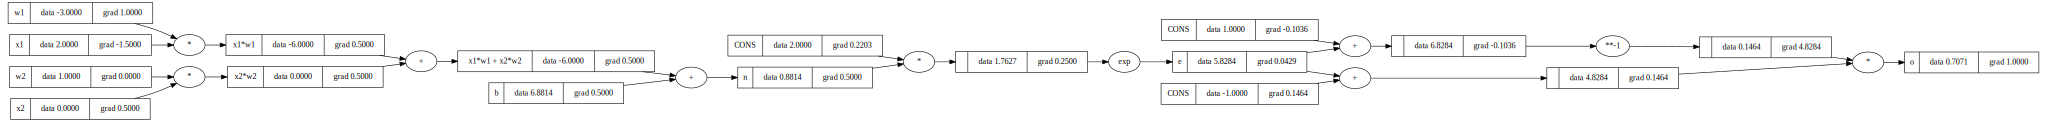

In [100]:
# inputs x1, x2 
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2 
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"

n = x1w1x2w2 + b; n.label='n' 
# print(n) 

# output 
# --------
# o = n.tanh()
# -------
e = (2 * n).exp(); e.label='e'

o = (e - 1) / (e + 1)
o.label='o'
o.backward()
draw_dot(o)

In [101]:
a = Value(2., label='a')
b = a + a; b.label='b'

b.backward()

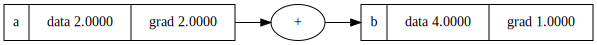

In [102]:
draw_dot(b)

In [103]:
import random

In [106]:
class Neruon: 
    def __init__(self, nin): 
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x): 
        # w * x + b 
        # print(list(zip(self.w, x))) # zip 将两个迭代器链在一起返回一个迭代器
        # act = sum((wi*xi for wi, xi in zip(self.w, x)), 0.0) + self.b # equals
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) 
        out = act.tanh()
        return out 

In [116]:
x = [-2, 3, 1]

n = Neruon(3)
n(x) # 这个会自动调用__call__方法,== n.__call__(x)

Value(data=0.9929621909263763)

In [169]:
class Neruon:
    def __init__(self, nin): 
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b =  Value(random.uniform(-1, 1))
        

    def __call__(self, x): 
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out  = act.tanh()
        return out 

    def parameters(self): 
        return self.w + [self.b]

class Layer: 
    def __init__(self, nin, nout): 
        self.neruons = [Neruon(nin) for _ in range(nout)]

    def __call__(self, x): 
        outs = [n(x) for n in self.neruons]
        return outs[0] if len(outs)==1 else  outs

    def parameters(self): 
        return [p for neruon in self.neruons for p in neruon.parameters()]
        # params = []
        # for neruon in self.neruons:
        #     ps = neruon.parameters()
        #     params.extend(ps) 
        # return params 

class MLP: 
    def __init__(self, nin, nouts):
        # size , 列表拼接
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x): 
        for layer in self.layers: 
            x = layer(x)
        return x 

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [170]:
x = [2.0, 3.0]
n = Layer(2, 3)
n(x)

[Value(data=-0.6067110138702344),
 Value(data=0.987308121893249),
 Value(data=0.9964822146745979)]

In [171]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.20996430182303608)

In [173]:
n.parameters(), len(n.parameters())

([Value(data=0.6362826650657805),
  Value(data=-0.16305784432768644),
  Value(data=-0.5528425144588993),
  Value(data=-0.10934744119035278),
  Value(data=-0.5597712840073239),
  Value(data=-0.4453243228393444),
  Value(data=-0.8140167882433513),
  Value(data=-0.24311350847221247),
  Value(data=-0.34170078302529494),
  Value(data=-0.9395914521474948),
  Value(data=0.2236374785232098),
  Value(data=0.18996947338396786),
  Value(data=0.6534263596855456),
  Value(data=-0.2413461024562833),
  Value(data=-0.7989343869742702),
  Value(data=0.9319013317208957),
  Value(data=0.8028838322400729),
  Value(data=-0.8124343707066815),
  Value(data=0.44655960537434414),
  Value(data=-0.9567586004074993),
  Value(data=-0.03655713313087405),
  Value(data=0.8617102804415004),
  Value(data=0.16606341744858),
  Value(data=0.5479525269863439),
  Value(data=-0.4011748926407426),
  Value(data=0.9682808381759609),
  Value(data=0.2445257351072454),
  Value(data=0.9846743642913016),
  Value(data=-0.073687996788

In [ ]:
draw_dot(n(x))

In [174]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0], 
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

ypred = [n(x) for x in xs]
ypred

[Value(data=-0.20996430182303608),
 Value(data=-0.32501811039063405),
 Value(data=-0.3816316879673772),
 Value(data=0.6786694112959849)]

In [175]:
# y ground truth, y output 
# 为什么这里就要Value(ygt) , 而不是直接ygt
[(Value(ygt) - yout)**2 for ygt, yout in zip(ys, ypred)]


[Value(data=1.4640136116861073),
 Value(data=0.4556005513006304),
 Value(data=0.38237936932607525),
 Value(data=0.10325334723686891)]

```
TypeError                                 Traceback (most recent call last)
Cell In[148], line 1
----> 1 loss = [(ygt - yout)**2 for ygt, yout in zip(ys, ypred)]

Cell In[148], line 1, in <listcomp>(.0)
----> 1 loss = [(ygt - yout)**2 for ygt, yout in zip(ys, ypred)]

TypeError: unsupported operand type(s) for -: 'float' and 'Value'
```

In [176]:
loss = sum([(Value(ygt) - yout)**2 for ygt, yout in zip(ys, ypred)])
loss 

Value(data=2.405246879549682)

In [177]:
loss.backward()

In [178]:
n.layers[0].neruons[0]  

In [179]:
n.layers[0].neruons[0].w[0]

Value(data=0.6362826650657805)

In [180]:
n.layers[0].neruons[0].w[0].grad

0.25110400857283216

In [181]:
 n.layers[0].neruons[0].w[0].data # 根据上面的梯度(0.25)应该减小这个值

0.6362826650657805

In [183]:
 # n.parameters()

In [190]:
for p in n.parameters(): 
    p.data += -0.01 * p.grad

In [191]:
n.layers[0].neruons[0].w[0].grad 

0.25110400857283216

In [192]:
n.layers[0].neruons[0].w[0].data

0.6337716249800521

In [215]:
# 从头开始, 这个完整的流程
# 共三层, [4, 4, 1]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.6506958397786515)

In [216]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0], 
    [2.0, -1.0, -1.0], 
]

ys = [1.0, -1.0, -1.0, 1.0, 1.0] # desired targets

In [217]:
for k in range(20): 
    # forward pass 
    ypred = [n(x) for x in xs ]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) 

    # backward 
    # 为什么要置为0 ? 置为0 之后下降的更加缓慢
    # 我知道了, 因为每次面对的都是更新过的parameters, 所以不可以累积之前的作为使用
    for p in n.parameters(): 
        p.grad = 0.0 
    loss.backward() 
    
    # update 
    for p in n.parameters(): 
        p.data += -0.05 * p.grad 

    print(k, loss.data)

0 5.304735221992904
1 4.13969406234457
2 2.7427326195692037
3 1.6046868087301878
4 0.8873092254138464
5 0.45395045598203754
6 0.26548981331621996
7 0.1796096057777241
8 0.13844134280837916
9 0.11272408369152617
10 0.09510672376040857
11 0.08227869766479048
12 0.07251608998352184
13 0.06483401355283991
14 0.05862913231581062
15 0.05351119158996995
16 0.049216533047917385
17 0.045560569145574076
18 0.04241017781685833
19 0.03966691291539691


In [218]:
ypred

[Value(data=0.9522826616789152),
 Value(data=-0.8750315627113374),
 Value(data=-0.8936595262228773),
 Value(data=0.9616780659263039),
 Value(data=0.9051528006407885)]